In [1]:
import pandas as pd
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.qda import QDA
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, roc_curve, auc  
from sklearn.metrics import classification_report  
from sklearn.cross_validation import train_test_split
%matplotlib inline  

### 1. 准备数据

### (1). 导入训练集

In [2]:
header = ['dev_id', 'post_id', 'stat_view', 'stat_click', 'max_stat_date', 'min_stat_date', 'ds', 'stat_view_1'  ,                                                                    
    'stat_click_1', 'stat_view_2', 'stat_click_2', 'p1', 'p1_time', 'p2', 'p2_time', 'ucnt1', 'upct1', 'ucnt2',
    'upct2', 'pcnt1', 'ppct1', 'pcnt2', 'ppct2', 'n'
]  

In [3]:
df = pd.read_csv('data/model_detail.csv', names= header)

###  (2). 数据混合

In [4]:
c1 = df['p2'] == 1
c2 = df['p2'] == 0
df = pd.concat([df[c1], df[c2].sample(len(df[c1]))])

### (3). 拆分建模和测试集

In [5]:
train, test = train_test_split(df, test_size=.5)
print 'len(train) = ', len(train)
print 'len(test) = ', len(test)

len(train) =  72303
len(test) =  72303


### 2. 建模

#### (1). 定义建模字段

In [6]:
xcols = [
    'stat_view', 'stat_click', 'stat_view_1', 'stat_click_1', 'stat_view_2', 'stat_click_2', 
    'ucnt1', 'upct1', 'ucnt2', 'upct2', 'pcnt1', 'ppct1', 'pcnt2', 'ppct2'
]
ycol = 'p2'

In [7]:
train_x = train[xcols]
train_y = train[ycol]
test_x = test[xcols]

#### (2). 创建分类器

In [8]:
# classifier = QDA()
# classifier = RandomForestClassifier(max_depth=6, n_estimators=10, max_features=4)
# classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
# classifier =DecisionTreeClassifier(max_depth=5)
#classifier = SVC(probability=True)   # ***慢 ***
#classifier = SVC(kernel="linear", C=0.025)
# classifier = SVC(gamma=2, C=1)
# classifier = KNeighborsClassifier(3)  # ***慢 ***
classifier = AdaBoostClassifier()
# classifier = GaussianNB()

#### (3). 建模并获取结果

In [9]:
classifier.fit(train_x, train_y) 
proba = classifier.predict_proba(test_x)
result = test
result['pct']  = proba[:,1]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### (4). 整理结果数据

In [10]:
result = result[['dev_id', 'post_id', 'p2', 'pct']]
result = result.sort_values('pct', ascending=False)
result['n'] = range(1, len(result)+1)
result['cumsum'] =  result['p2'].cumsum() 
stat = result['cumsum'] / result['n']

#### (5). 作图

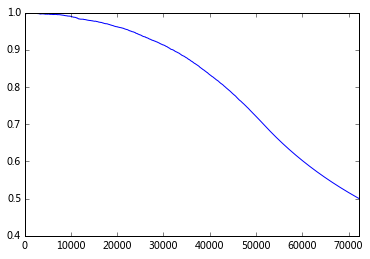

In [11]:
stat.reset_index(drop=True).plot()

### 3. 保存分类器

In [12]:
pickle.dump(classifier, open('p2.pk', 'wb'))